In [1]:
# %matplotlib inline
%matplotlib widget
from hydrophone_data_processing import load, preprocessing, tempmatch
import obspy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import sklearn.metrics as metrics

from obspy.signal.tf_misfit import cwt

class PrecisionDateFormatter(ticker.Formatter):
    """
    Extend the `matplotlib.ticker.Formatter` class to allow for millisecond
    precision when formatting a tick (in days since the epoch) with a
    `~datetime.datetime.strftime` format string.

    """

    def __init__(self, fmt, precision=3, tz=None):
        """
        Parameters
        ----------
        fmt : str
            `~datetime.datetime.strftime` format string.
        """
        from matplotlib.dates import num2date
        if tz is None:
            from matplotlib.dates import _get_rc_timezone
            tz = _get_rc_timezone()
        self.num2date = num2date
        self.fmt = fmt
        self.tz = tz
        self.precision = precision

    def __call__(self, x, pos=0):
        if x == 0:
            raise ValueError("DateFormatter found a value of x=0, which is "
                             "an illegal date; this usually occurs because "
                             "you have not informed the axis that it is "
                             "plotting dates, e.g., with ax.xaxis_date()")

        dt = self.num2date(x, self.tz)
        ms = dt.strftime("%f")[:self.precision]

        return dt.strftime(self.fmt).format(ms=ms)

    def set_tzinfo(self, tz):
        self.tz = tz
        
def minnaert_radius(freq, depth):
    # https://www.engineeringtoolbox.com/specific-heat-capacity-gases-d_159.html
    gamma = 1.405 # taken from website above for 300K
    rho = 997 # kg/m^3
    PA = (rho * 9.8 * depth) + 100000 # kg/(m*s^2)
    # PA/rho => PA(kg*m^-1*s^-2) / rho(kg * m^-3) =? PA(...) * rho(kg^-1 * m^3) => m^2 * s^-2
    return (2 * np.pi * freq)**(-1) * ((3 * gamma * PA)/(rho))**(1/2)

def ideal_gas_n(pressure, volume):
    P = pressure
    V = volume
    R = 8.31446261815324 # J K^−1 mol^−1
    T = 34.75 + 273.15 # K
    n = (P * V)/(R * T)
    return n

def get_mass(pressure, volume):
    n = ideal_gas_n(pressure, volume)
    avogadros_n = 6.0221409e23
    h2_mass = 1.6735575e-27
    return n * avogadros_n * h2_mass

# volume = lambda r: (4/3)*np.pi*r**3

def volume(r):
    return (4/3) * np.pi * r**3

# DATA IMPORT

## import bubble detections from matched filter

In [2]:
bubbles = load.import_bubble_detections('/media/sda/data/borehole/detections/*.csv')
bubbles.reset_index(inplace=True)

# calculate minnaert radius
bubbles['min_radius'] = minnaert_radius(freq=250, depth=15)
bubbles['max_radius'] = minnaert_radius(freq=200, depth=15)
bubbles['mean_radius'] = np.mean([minnaert_radius(freq=200, depth=15), minnaert_radius(freq=250, depth=15)])

# calculate volumes
bubbles['volume_min'] = bubbles.min_radius.apply(volume)
bubbles['volume_max'] = bubbles.max_radius.apply(volume)
bubbles['volume_mean'] = bubbles.mean_radius.apply(volume)

#  calculate mass
bubbles['mass_min'] = bubbles.volume_min.apply(lambda v: get_mass(pressure=(997 * 9.8 * 15) + 100000, volume=v))
bubbles['mass_max'] = bubbles.volume_max.apply(lambda v: get_mass(pressure=(997 * 9.8 * 15) + 100000, volume=v))
bubbles['mass_mean'] = bubbles.volume_mean.apply(lambda v: get_mass(pressure=(997 * 9.8 * 15) + 100000, volume=v))

In [3]:
# bubsub = bubbles[bubbles.time.between('2019-05-18','2019-05-19')]

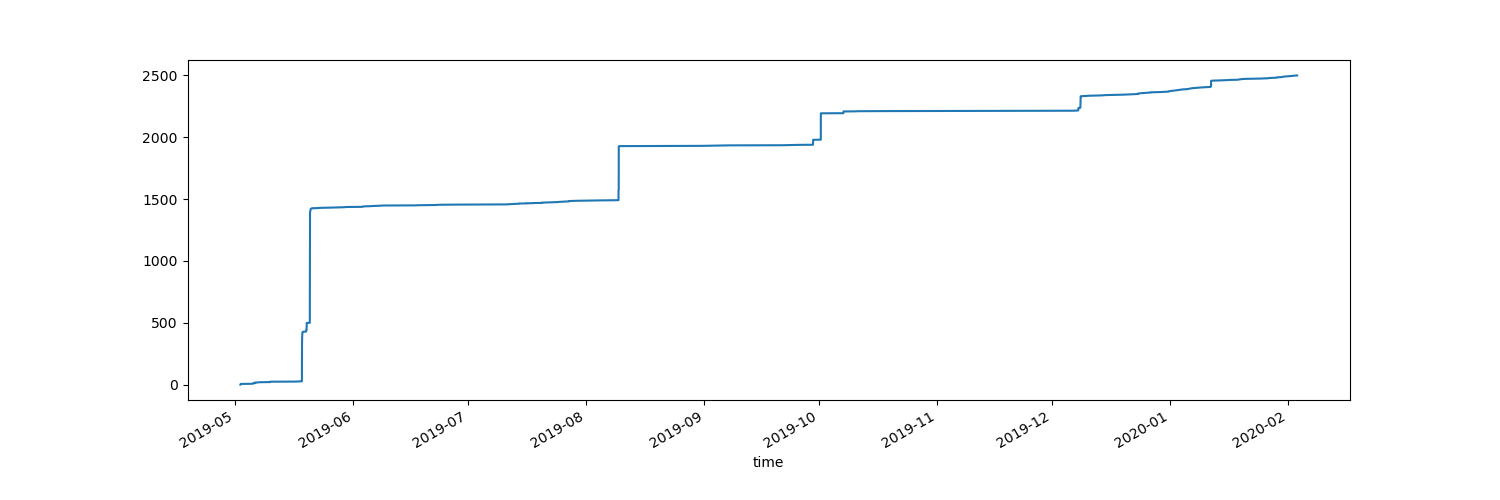

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))
bubbles.set_index('time').ones.cumsum().plot(ax=ax)
# alpha = 
# nt = 400*(1- np.exp(-alpha*t))
event1 = bubbles[bubbles.time.between('2019-05-18 11:30:00', '2019-05-18 14:00:00')].copy()
# event2 = bubbles[bubbles.time.between('2019-05-18 11:30:00', '2019-05-19 12:45:00')].copy()
# event3 = bubbles[bubbles.time.between('2019-05-20 13:35:30', '2019-05-21 14:30:00')].copy()
event3 = bubbles[bubbles.time.between('2019-05-20 13:35:30', '2019-05-20 14:20:00')].copy()
event4 = bubbles[bubbles.time.between('2019-08-09 11:00:00','2019-08-09 12:15:00')].copy()

event5 = bubbles[bubbles.time.between('2019-08-09 13:00:00','2019-08-09 13:15:00')].copy()

# event5point5 = bubbles[bubbles.time.between('2019-08-09 13:15:00','2019-08-09 13:27:00')].copy()
event5point5 = bubbles[bubbles.time.between('2019-08-09 13:17:00','2019-08-09 13:27:00')].copy()

event6 = bubbles[bubbles.time.between('2019-09-29 11:00:00','2019-09-29 11:30:00')].copy()
event7 = bubbles[bubbles.time.between('2019-10-01 12:00:00','2019-10-01 13:00:00')].copy()
event8 = bubbles[bubbles.time.between('2019-10-07 10:55:00','2019-10-07 11:05:00')].copy()
event9 = bubbles[bubbles.time.between('2019-12-08 00:00:00','2019-12-08 01:00:00')].copy()
# event9 = bubbles[bubbles.time.between('2019-12-08 00:00:00','2019-12-08 01:00:00')].copy()
event10 = bubbles[bubbles.time.between('2019-12-08 12:50:00','2019-12-08 13:00:00')].copy()
event11 = bubbles[bubbles.time.between('2019-12-08 13:30:00','2019-12-08 15:30:00')].copy()

In [38]:
events = [
    event1
    ,event3
    ,event4
    ,event5
    ,event5point5
    ,event6
    ,event7
    ,event8
    ,event9
    ,event10
    ,event11
]

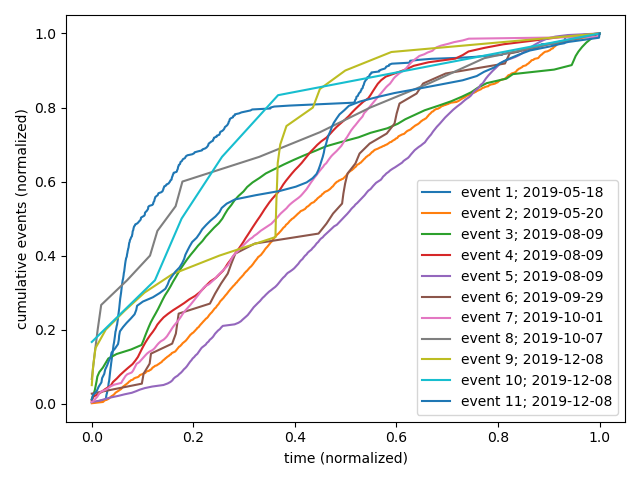

In [39]:
# events = [event1
#           # , event2
#           , event3, event4, event5, event5point5, event6, event7, event8
#           # , event9
#           , event10, event11]
fig, ax = plt.subplots()

for n, e in enumerate(events):
    y = e.ones.cumsum()
    y = y/y.max()
    time = e.time
    t = np.array([t.timestamp() for t in time])
    t = (t - t.min())
    t = t/t.max()
    ax.plot(t, y, label='event {n}; {t}'.format(n=n+1, t=time.min().date()))

ax.legend()
ax.set_ylabel('cumulative events (normalized)')
ax.set_xlabel('time (normalized)')

fig.tight_layout()

2193     1
2194     2
2195     3
2196     4
2197     5
2198     6
2199     7
2200     8
2201     9
2202    10
2203    11
2204    12
2205    13
2206    14
2207    15
Name: ones, dtype: int64

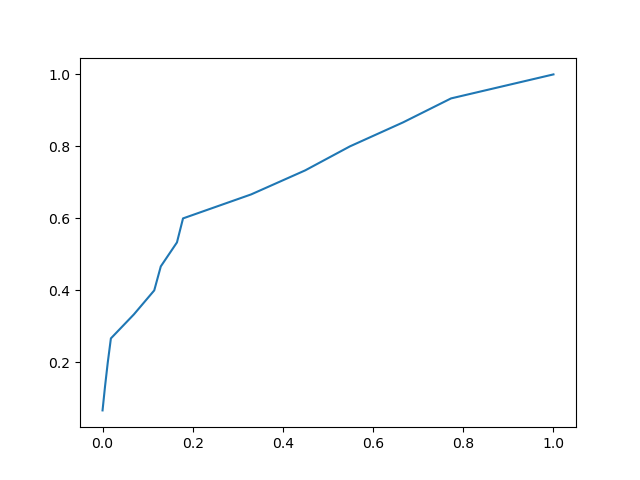

In [40]:
fig, ax = plt.subplots()
e = event8
y = e.ones.cumsum()
y = y/y.max()
time = e.time
t = np.array([t.timestamp() for t in time])
t = (t - t.min())
t = t/t.max()

ax.plot(t, y)
event8.ones.cumsum()

[8.44274722e+01 2.97805329e-03]
A:84.42747217134435 alpha:0.0029780532880111787


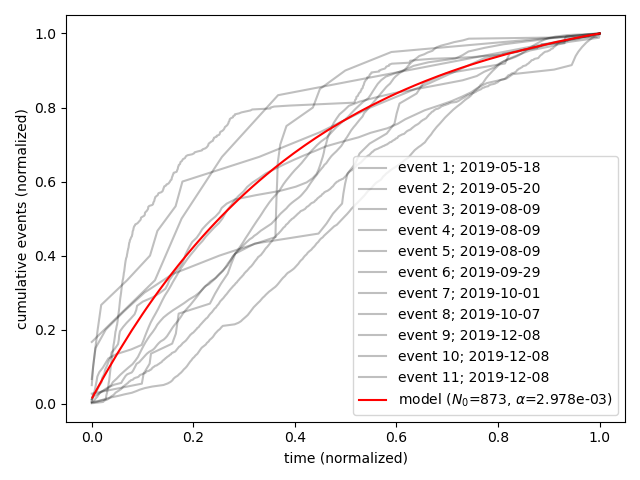

In [41]:
# events = [event1
#           # , event2
#           , event3, event4, event5, event6, event7, event8
#           # , event9
#           , event10, event11]
fig, ax = plt.subplots()

for n, e in enumerate(events):
    y = e.ones.cumsum()
    y = y/y.max()
    time = e.time
    t = np.array([t.timestamp() for t in time])
    t = (t - t.min())
    t = t/t.max()
    ax.plot(t, y, label='event {n}; {t}'.format(n=n+1, t=time.min().date()), color='black', alpha=0.25)

ax.set_ylabel('cumulative events (normalized)')
ax.set_xlabel('time (normalized)')

from scipy import optimize
def curvefunc(t, a, b):
    return 1+a*(1 - np.exp(-b*t))

# e = event3
e = event4
y = e.set_index('time').ones.cumsum().values
time = e.set_index('time').ones.cumsum().index
t = np.array([t.timestamp() for t in time])
t = t - t.min()
t = t + 1
params, cov = optimize.curve_fit(curvefunc, t, y, p0=(871, 5/10800))
print(params)
A, alpha = params
print('A:'+str(params[0]),'alpha:'+str(params[1]))
# nt_fit = curvefunc(t, a=A, b=alpha)
# nt_fit = curvefunc(t, a=871, b=alpha)
nt_fit = curvefunc(t, a=e.shape[0], b=alpha)


# ax.plot(t/t.max(), nt_fit/nt_fit.max(), color='red', label=r'model ($N_0$={A}'.format(A=int(params[0]))+r', $\alpha$={:.3e})'.format(params[1]))
ax.plot(t/t.max(), nt_fit/nt_fit.max(), color='red', label=r'model ($N_0$={A}'.format(A=int(873))+r', $\alpha$={:.3e})'.format(params[1]))
  
ax.legend()

fig.tight_layout()
fig.savefig('supp_alldegass.pdf', bbox_inches='tight')

N-events: 380 A: 351.43946327921486 alpha: 0.0008132643498728344 r2: 0.9316534481710586
N-events: 871 A: 2837.4017333209385 alpha: 0.0001603004093083399 r2: -0.9249956543639644
N-events: 82 A: 84.42747068937715 alpha: 0.0029780534013881914 r2: 0.9866661841603263
N-events: 103 A: 191.51425734211438 alpha: 0.002123603235228541 r2: 0.1387046163922061
N-events:238 Optimal parameters not found: Number of calls to function has reached maxfev = 600.
N-events: 37 A: 153.90955454080495 alpha: 0.0006398790349415184 r2: -1.2320751316698444
N-events: 214 A: 726.5400281006208 alpha: 0.0005082928270025862 r2: -0.9890698613934643
N-events: 15 A: 12.879323991526755 alpha: 0.014194921589149858 r2: 0.8639107000262424
N-events: 20 A: 24.313099505242345 alpha: 0.0009700686884187918 r2: 0.7913245162527638
N-events: 6 A: 5.476845424360296 alpha: 0.008028040983613231 r2: 0.931028184877367
N-events: 87 A: 91.09933967581688 alpha: 0.0003907431705509778 r2: 0.978679202918782


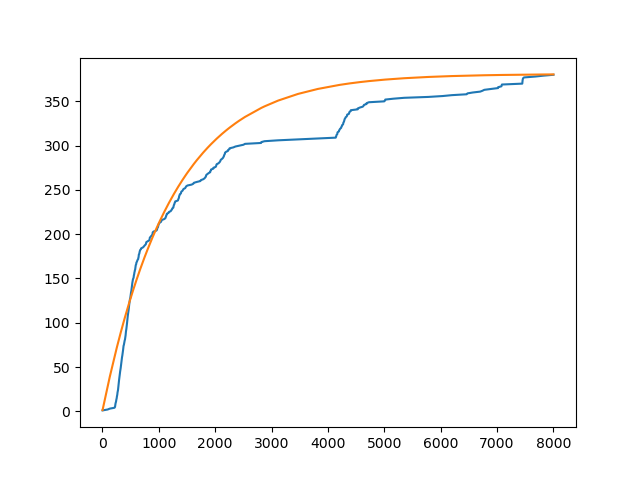

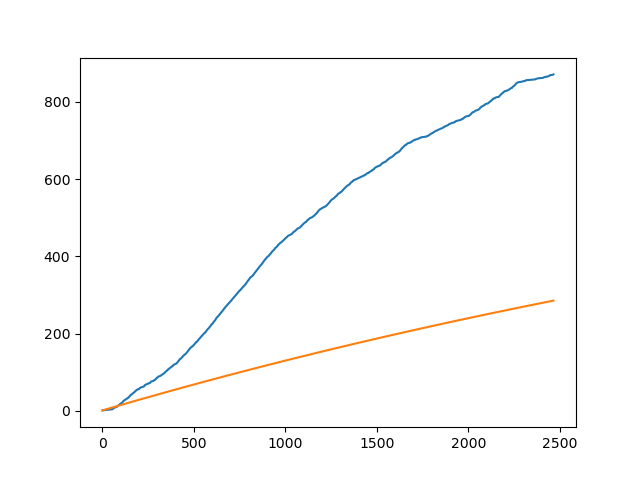

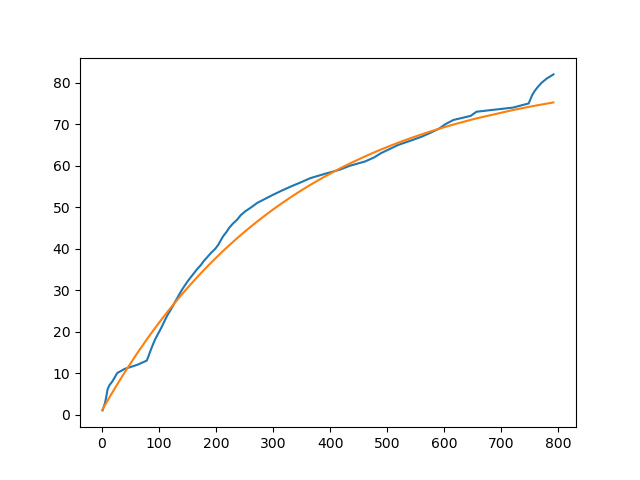

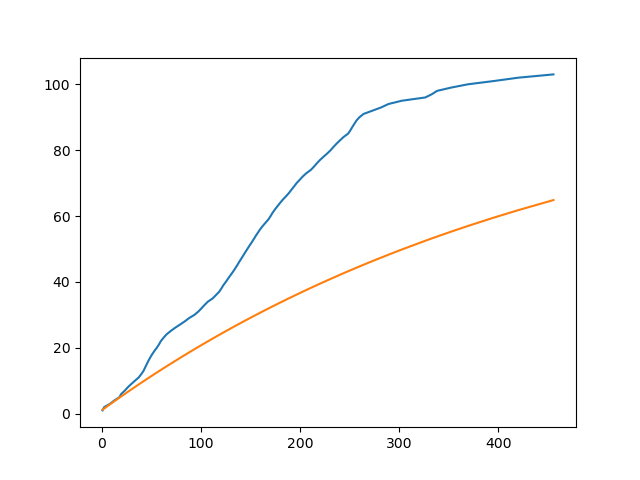

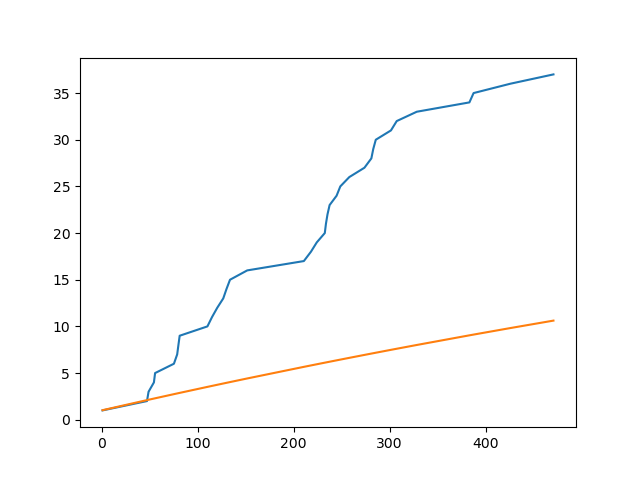

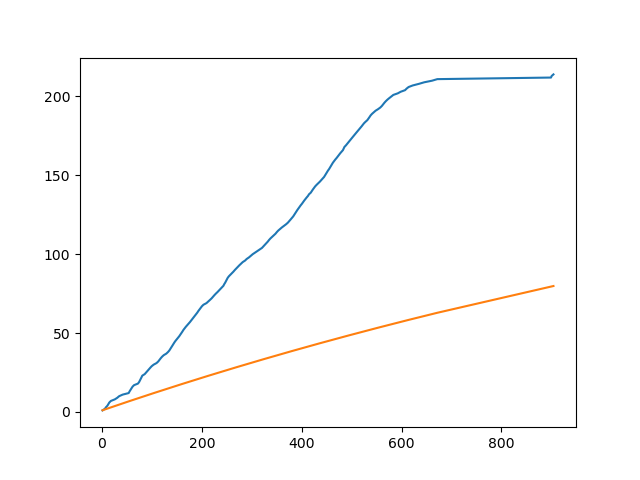

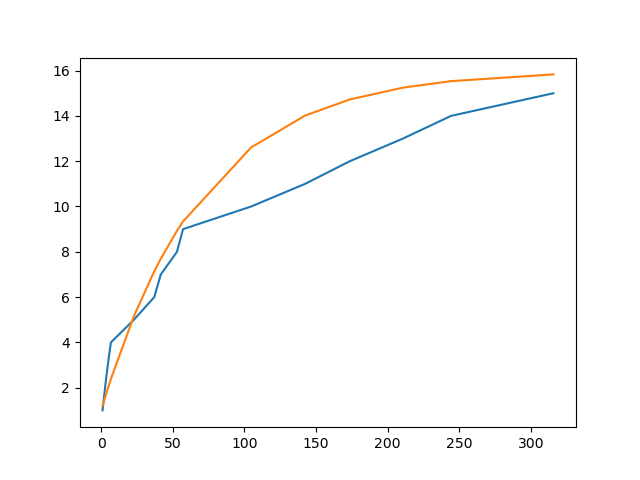

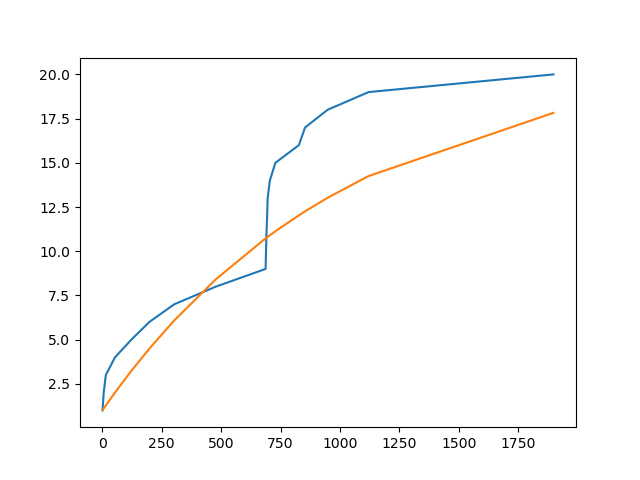

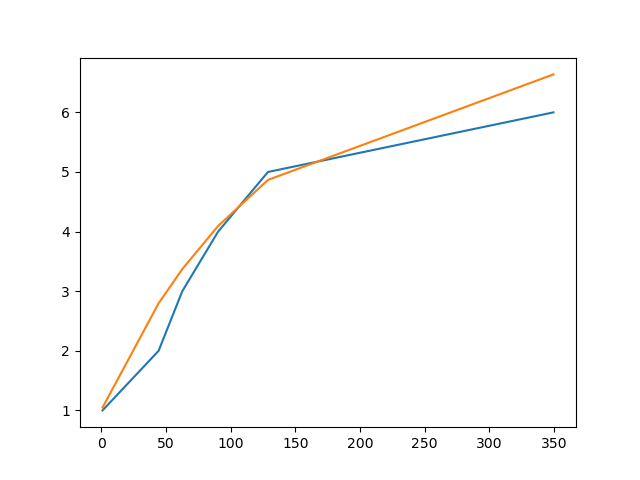

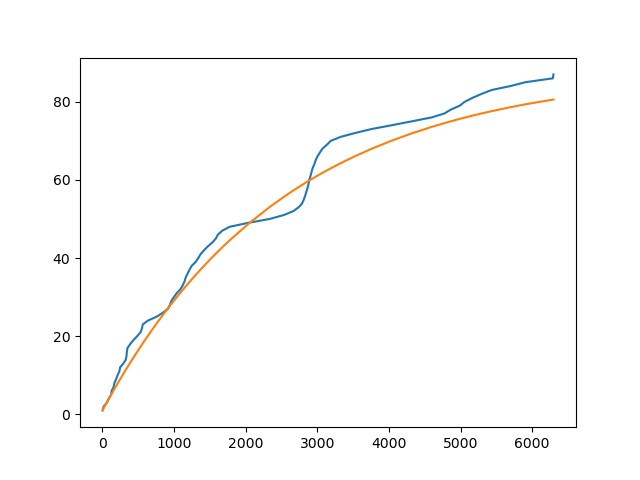

In [51]:
As = []
alphas = []
for e in events:
    try:
        y = e.set_index('time').ones.cumsum().values
        time = e.set_index('time').ones.cumsum().index
        t = np.array([t.timestamp() for t in time])
        t = t - t.min()
        t = t + 1
        params, cov = optimize.curve_fit(curvefunc, t, y, p0=(e.shape[0], 5/10800))
        # print(params)
        
        A, alpha = params
        
        nt = curvefunc(t, a=y.shape[0], b=alpha)
        # nt = curvefunc(t, a=y.shape[0], b=2.978e-4)
        
        r2 = metrics.r2_score(y_true=y, y_pred=nt)
        print('N-events:', str(y.shape[0]), 'A:', A, 'alpha:', alpha, 'r2:', r2)
        As.append(params[0])
        alphas.append(params[1])
        
        fig, ax = plt.subplots()
        ax.plot(t, y)
        ax.plot(t, nt)
        
    except RuntimeError as e:
        print('N-events:'+str(y.shape[0]),e)

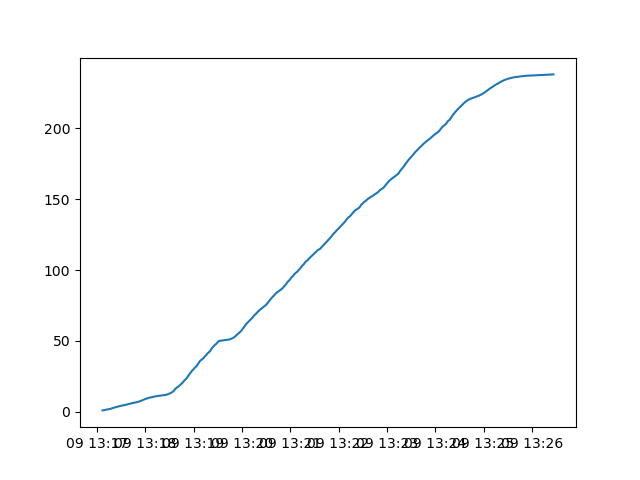

In [43]:
# e = events[4]
e = event5point5
t = e.time

y = e.ones.cumsum()

fig, ax = plt.subplots()
ax.plot(t, y)


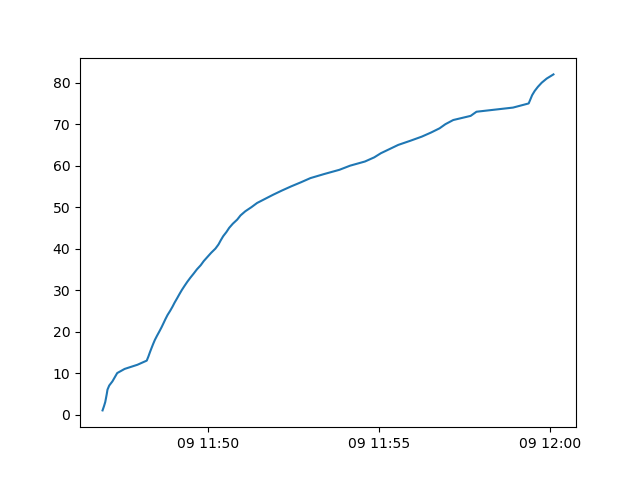

In [25]:
fig, ax = plt.subplots()

t = event4.time
y = event4.ones.cumsum()

ax.plot(t, y)

In [169]:
events = [event1
          # , event2
          , event3, event4, event5, event6, event7, event8
          # , event9
          , event10, event11]

,time,similarity,template_id,ones,min_radius,max_radius,mean_radius,volume_min,volume_max,volume_mean,mass_min,mass_max,mass_mean
2236,2019-12-08 12:53:54.016000+00:00,0.925914,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005
2237,2019-12-08 12:54:37.346000+00:00,0.926221,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005
2238,2019-12-08 12:54:55.641000+00:00,0.933412,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005
2239,2019-12-08 12:55:23.343000+00:00,0.930963,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005
2240,2019-12-08 12:56:01.829000+00:00,0.912864,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005
2241,2019-12-08 12:59:42.444000+00:00,0.919758,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005


[3.62105386e+02 7.69797291e-04] [[ 6.89100404e+00 -2.67359119e-05]
 [-2.67359119e-05  2.02730118e-10]]
rmse homemade: 39.6457322487158
rmse scipy.optimize: 33.5724025728551
r2 homemade: 0.8832855267139696
r2 scipy.optimize: 0.9163055477053881


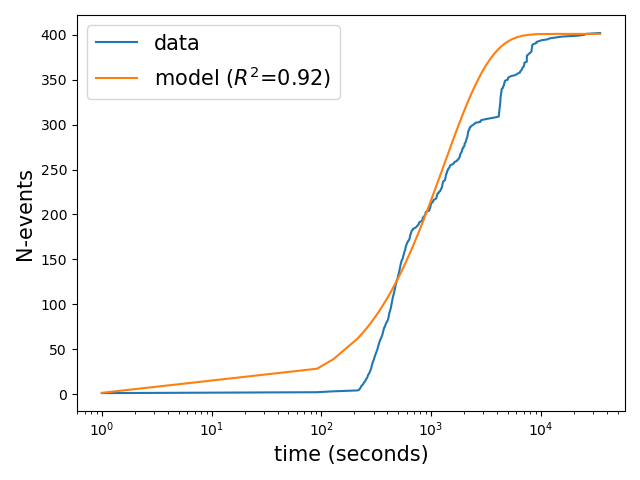

In [95]:
# >>> scipy.optimize.curve_fit(lambda t,a,b: a*numpy.exp(b*t),  x,  y,  p0=(4, 0.1))
# >>> scipy.optimize.curve_fit(lambda t,a,b: a*numpy.exp(b*t),  x,  y,  p0=(4, 0.1))
# (array([ 4.88003249,  0.05531256]),
#  array([[  1.01261314e+01,  -4.31940132e-02],
#         [ -4.31940132e-02,   1.91188656e-04]]))
# # y ≈ 4.88 exp(0.0553 x). much better.

y = bubsub.set_index('time').ones.cumsum().values
time = bubsub.set_index('time').ones.cumsum().index

t = np.array([t.timestamp() for t in time])
t = t - t.min()
t = t + 1
alpha = 1/(t[-1] - t[0])
alpha = 5/10800
nt = 1 + 400*(1 - np.exp(-alpha*t))

fig, ax = plt.subplots()
# ax.plot(t, nt, label='model')
ax.plot(t, y, label='data')

# ax.set_xlim(1e0, 4e4)

from scipy import optimize
def curvefunc(t, a, b):
    return 1+a*(1 - np.exp(-b*t))

params, cov = optimize.curve_fit(curvefunc, t, y, p0=(450, 50/10800))
A, alpha = params
# nt_fit = 1 + A*(1-)
print(params, cov)
# nt_fit = 1 + A*(1 - np.exp(-alpha*t))
# nt_fit = curvefunc(t, a=A, b=alpha)
nt_fit = curvefunc(t, a=400, b=alpha)

# ax.plot(t, nt_fit, label='scipy.optimize')
ax.plot(t, nt_fit, label='model ($R^2$={r2})'.format(r2=round(metrics.r2_score(y_true=y, y_pred=nt_fit),2)))

ax.legend(fontsize=15)
ax.set_xscale('log')

ax.set_xlabel('time (seconds)', fontsize=15)
ax.set_ylabel('N-events', fontsize=15)
fig.tight_layout()
fig.savefig('supp2_model.pdf', bbox_inches='tight')

print('rmse homemade:', np.sqrt(metrics.mean_squared_error(y_true=y, y_pred=nt)))
print('rmse scipy.optimize:', np.sqrt(metrics.mean_squared_error(y_true=y, y_pred=nt_fit)))


print('r2 homemade:', metrics.r2_score(y_true=y, y_pred=nt))
print('r2 scipy.optimize:', metrics.r2_score(y_true=y, y_pred=nt_fit))

[3.62105386e+02 7.69797291e-04] [[ 6.89100404e+00 -2.67359119e-05]
 [-2.67359119e-05  2.02730118e-10]]


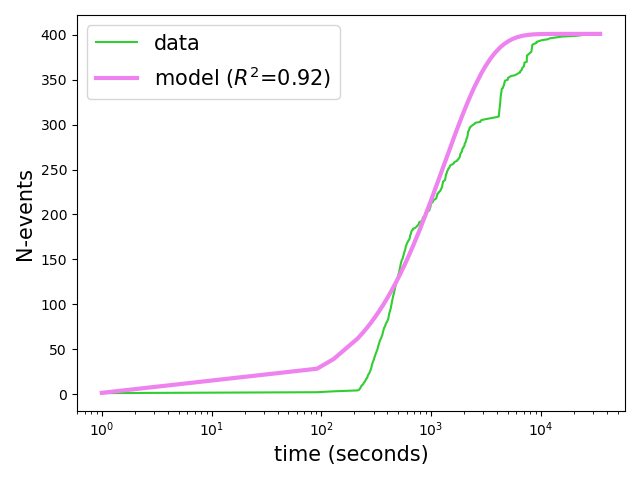

In [22]:
# >>> scipy.optimize.curve_fit(lambda t,a,b: a*numpy.exp(b*t),  x,  y,  p0=(4, 0.1))
# >>> scipy.optimize.curve_fit(lambda t,a,b: a*numpy.exp(b*t),  x,  y,  p0=(4, 0.1))
# (array([ 4.88003249,  0.05531256]),
#  array([[  1.01261314e+01,  -4.31940132e-02],
#         [ -4.31940132e-02,   1.91188656e-04]]))
# # y ≈ 4.88 exp(0.0553 x). much better.

y = bubsub.set_index('time').ones.cumsum().values
time = bubsub.set_index('time').ones.cumsum().index

t = np.array([t.timestamp() for t in time])
t = t - t.min()
t = t + 1

fig, ax = plt.subplots()
ax.plot(t, y, label='data', color='limegreen')


from scipy import optimize
def curvefunc(t, a, b):
    return 1+a*(1 - np.exp(-b*t))

params, cov = optimize.curve_fit(curvefunc, t, y, p0=(450, 50/10800))
A, alpha = params
print(params, cov)
nt_fit = curvefunc(t, a=400, b=alpha)

ax.plot(t, nt_fit, color='violet', linewidth=3, label='model ($R^2$={r2})'.format(r2=round(metrics.r2_score(y_true=y, y_pred=nt_fit),2)))

ax.legend(fontsize=15)
ax.set_xscale('log')

ax.set_xlabel('time (seconds)', fontsize=15)
ax.set_ylabel('N-events', fontsize=15)
fig.tight_layout()
fig.savefig('supp2_model.pdf', bbox_inches='tight')

In [142]:
t.shape

(402,)

In [24]:
dts = []
deltaT = [0,]
for n in np.arange(0, bubbles.shape[0], 1):
    if n+1 == bubbles.shape[0]:
        break
        
    dt = bubbles.time[n+1] - bubbles.time[n]
    dts.append(dt)
    # deltaT.append(dt.seconds)
    deltaT.append(dt.seconds+dt.microseconds*1e-6)
    
bubbles['TimeDelta'] = dt
bubbles['deltaT_sec'] = deltaT

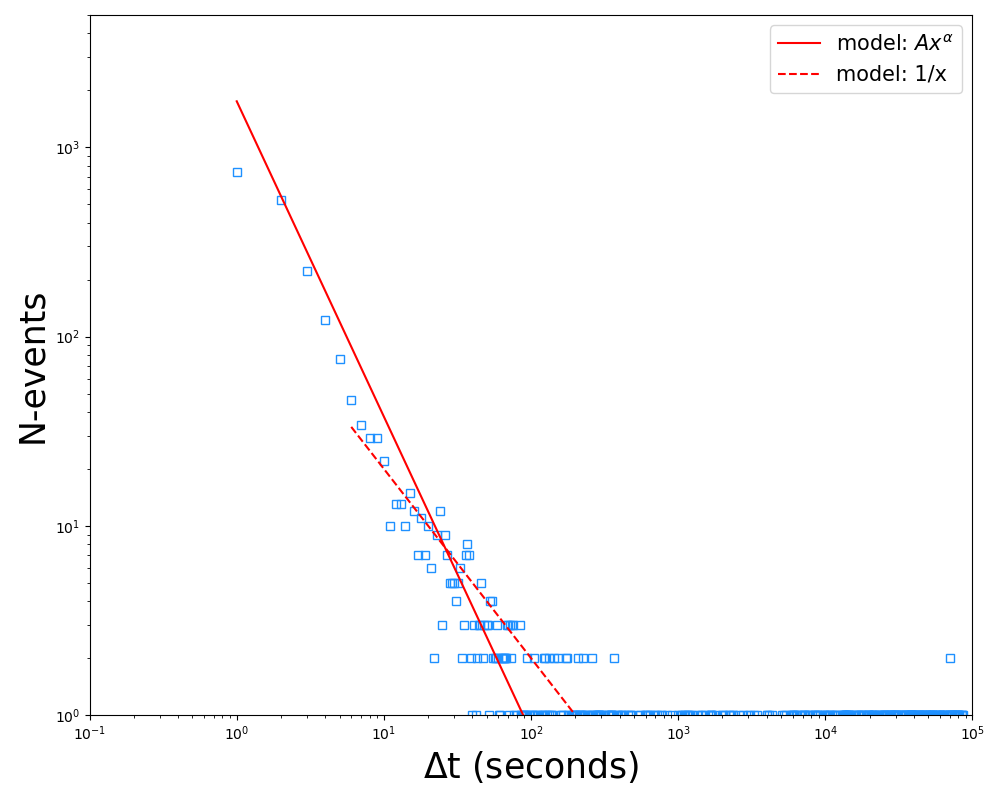

In [25]:
h, e = np.histogram(bubbles.deltaT_sec[1:], bins=np.linspace(0, 100000, 100000) )
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(e[:-1], h, color='dodgerblue', linewidth=0, marker='s', fillstyle='none')
# ax.set_xscale('log')
ax.set_xlim(1e-1, 1e5)
ax.set_ylim(1e0, 5e3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('N-events', fontsize=25)
ax.set_xlabel('$\Delta$t (seconds)', fontsize=25)

x = np.arange(1e0, 2e2)
y = 1750*x**(-1.666) # satan number
ax.plot(x, y, color='red', label=r'model: $A x^{\alpha}$')
ax.plot(x[5:], 200*1/x[5:], color='red', linestyle='--', label='model: 1/x')
# ax.plot(h[h<0], color='red', marker='s')

ax.legend(fontsize=15)

fig.tight_layout()
fig.savefig('intereventtime.pdf', bbox_inches='tight')

In [196]:
x

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

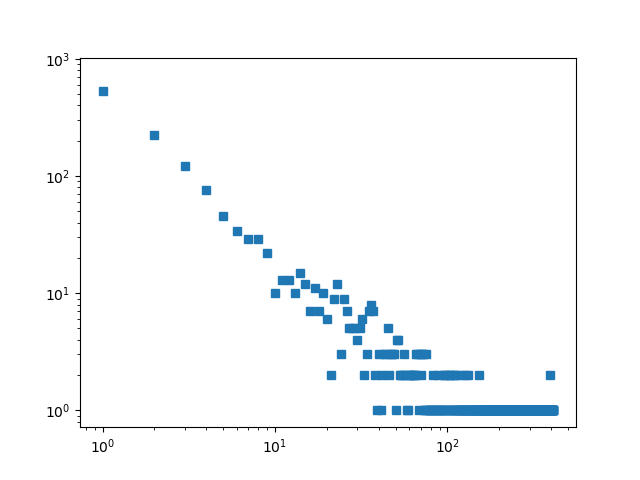

In [50]:
fig, ax = plt.subplots()
ax.plot( h[h>0], marker='s', linewidth=0)
ax.set_yscale('log')
ax.set_xscale('log')

In [10]:
bubbles.deltaT_sec[1:].min()

1.103

In [11]:
bubbles.deltaT_sec[1:].max()

86145.286

In [12]:
e

array([0.00000e+00, 1.00001e+00, 2.00002e+00, ..., 9.99980e+04,
       9.99990e+04, 1.00000e+05])

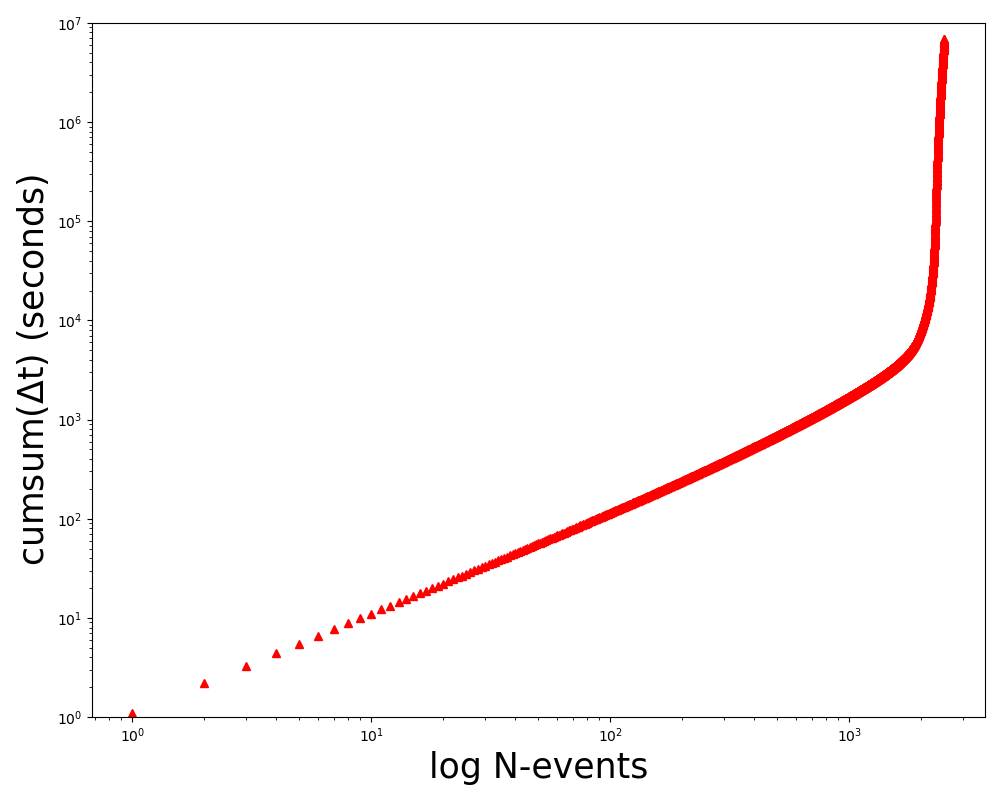

In [21]:
x = bubbles.deltaT_sec[1:].sort_values()
y = x.cumsum()

fig, ax = plt.subplots(figsize=(10, 8))
# ax.plot(x, y, color='red')
ax.plot(np.arange(1, x.shape[0]+1, 1), y, color='red', marker='^', linewidth=0)
# ax.plot([0, 1e5], [0, 1e5])
ax.set_ylim(1e0, 1e7)
# ax.set_xlim(1e-1, 1e5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('cumsum($\Delta$t) (seconds)', fontsize=25)
ax.set_xlabel('log N-events', fontsize=25)
fig.tight_layout()

In [14]:
bubbles.deltaT_sec[1:].sort_values().max()

86145.286

In [15]:
x

828         1.103000
927         1.105000
2412        1.105000
162         1.105000
682         1.105000
            ...     
1471    81387.781000
1932    84342.382999
1472    84685.098000
1432    85224.280000
1456    86145.286000
Name: deltaT_sec, Length: 2498, dtype: float64